In [1]:
from pymc_experimental.model import modular
import pymc as pm
import pandas as pd
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

In [2]:
def load_radon():
    srrs2 = pd.read_csv(pm.get_data("srrs2.dat"))
    srrs2.columns = srrs2.columns.map(str.strip)
    srrs_mn = srrs2[srrs2.state == "MN"].copy()

    cty = pd.read_csv(pm.get_data("cty.dat"))

    srrs_mn["fips"] = srrs_mn.stfips * 1000 + srrs_mn.cntyfips
    cty_mn = cty[cty.st == "MN"].copy()
    cty_mn["fips"] = 1000 * cty_mn.stfips + cty_mn.ctfips

    srrs_mn = srrs_mn.merge(cty_mn[["fips", "Uppm"]], on="fips")
    srrs_mn = srrs_mn.drop_duplicates(subset="idnum")

    srrs_mn.county = srrs_mn.county.map(str.strip)
    county, mn_counties = srrs_mn.county.factorize()
    srrs_mn["county_code"] = county
    srrs_mn["log_radon"] = log_radon = np.log(srrs_mn.activity + 0.1).values

    df = srrs_mn[["county", "floor", "log_radon"]].copy()
    floor_dict = {0: "Basement", 1: "Floor"}
    df["floor"] = df["floor"].apply(floor_dict.get)

    return df

In [3]:
df = load_radon()

In [4]:
alpha = modular.Intercept("alpha")
floor_effect = modular.Regression("floor_effect", feature_columns="floor")

model_1 = modular.NormalLikelihood(
    mu=alpha + floor_effect, sigma=None, data=df, target_col="log_radon"
)

In [5]:
model_1

             Variable  Expression              Dimensions                
─────────────────────────────────────────────────────────────────────────
 log_radon_observed =  Data                    obs_idx[919]              
             X_data =  Data                    obs_idx[919] × feature[2] 
                                                                         
              alpha ~  Normal(0, 1)                                      
       floor_effect ~  Normal(0, 1)            floor_effect_features[1]  
              sigma ~  Exponential(f())                                  
                                               Parameter count = 3       
                                                                         
                 mu =  f(alpha, floor_effect)  obs_idx[919]              
                                                                         
          log_radon ~  Normal(mu, sigma)       obs_idx[919]

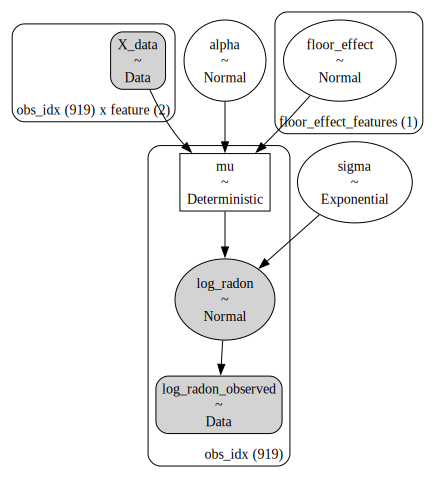

In [6]:
model_1.to_graphviz()

In [7]:
idata = model_1.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, floor_effect, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [8]:
az.summary(idata, var_names=["alpha", "floor_effect"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.361,0.028,1.305,1.411,0.000,0.000,4729.0,3305.0,1.0
floor_effect[floor],-0.583,0.070,-0.710,-0.444,0.001,0.001,4830.0,3010.0,1.0


In [9]:
county_effect = modular.Intercept("alpha", pooling_columns="county", pooling="none")
model_2 = modular.NormalLikelihood(
    mu=county_effect + floor_effect, sigma=None, data=df, target_col="log_radon"
)
model_2

              Variable  Expression                            Dimensions                
────────────────────────────────────────────────────────────────────────────────────────
  log_radon_observed =  Data                                  obs_idx[919]              
              X_data =  Data                                  obs_idx[919] × feature[2] 
                                                                                        
            alpha_mu ~  Normal(0, 1)                                                    
 alpha_county_effect ~  Normal(alpha_mu, 1)                   county[85]                
        floor_effect ~  Normal(0, 1)                          floor_effect_features[1]  
               sigma ~  Exponential(f())                                                
                                                              Parameter count = 88      
                                                                                        
                  mu =  f(alpha_county_effect, floor_effect)  obs_idx[919]              
                                                                                        
           log_radon ~  Normal(mu, sigma)                     obs_idx[919]

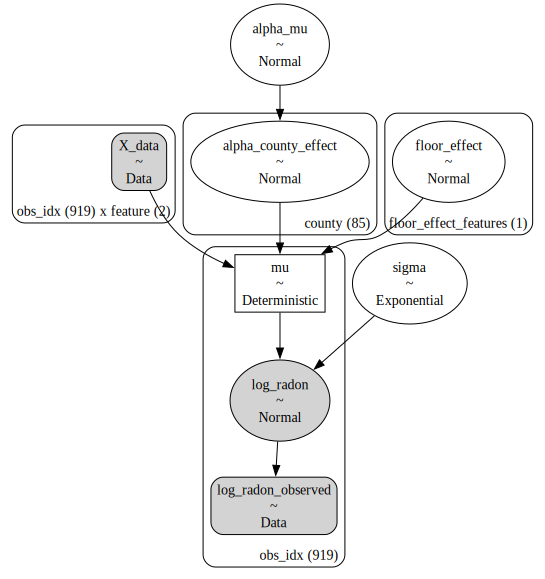

In [10]:
model_2.to_graphviz()

In [11]:
idata_2 = model_2.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_mu, alpha_county_effect, floor_effect, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


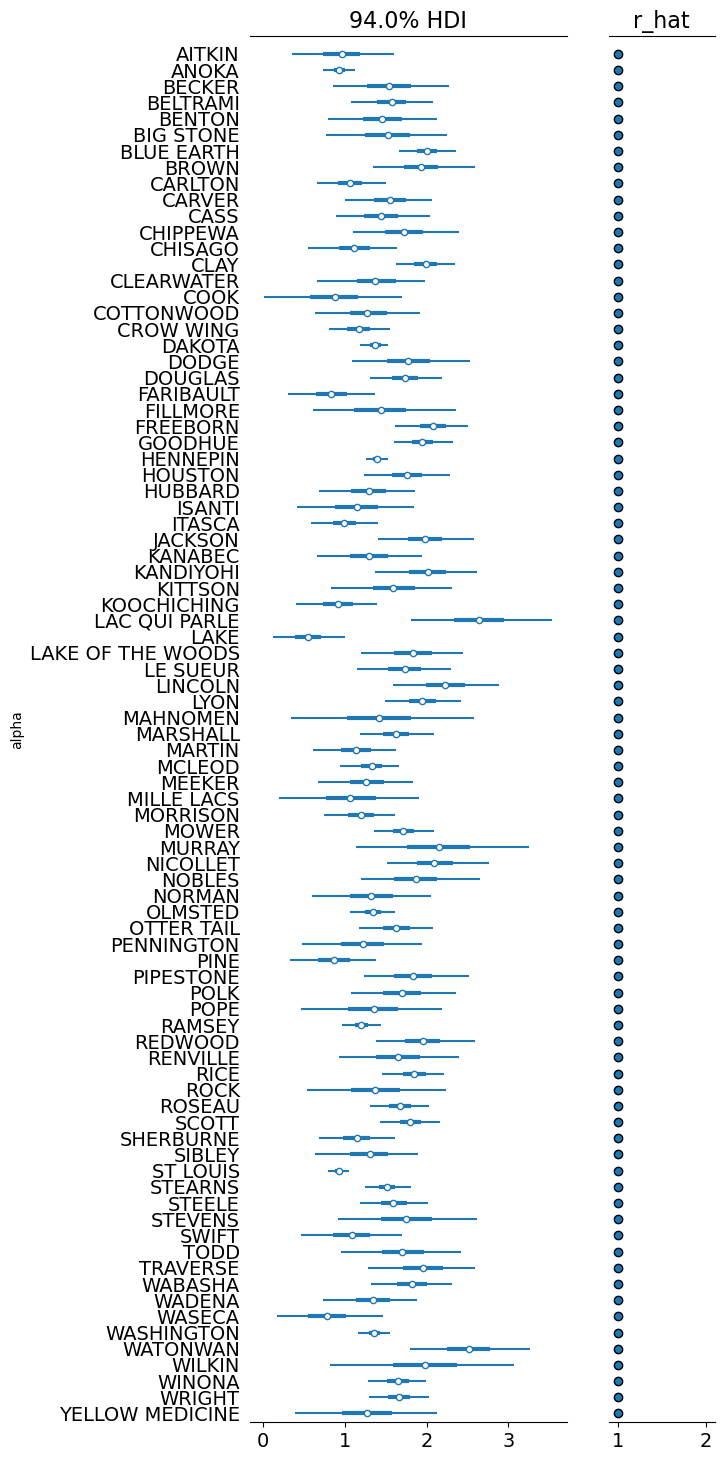

In [12]:
ax = az.plot_forest(
    idata_2,
    var_names=["alpha_county_effect"],
    r_hat=True,
    combined=True,
    figsize=(6, 18),
    labeller=az.labels.NoVarLabeller(),
)
ax[0].set_ylabel("alpha");

In [13]:
county_effect.pooling = "partial"

model_3 = modular.NormalLikelihood(
    mu=county_effect + floor_effect, sigma=None, data=df, target_col="log_radon"
)
model_3

                     Variable  Expression                                                Dimensions                
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         log_radon_observed =  Data                                                      obs_idx[919]              
                     X_data =  Data                                                      obs_idx[919] × feature[2] 
                                                                                                                   
                      alpha ~  Normal(0, 1)                                                                        
  alpha_county_effect_sigma ~  Gamma(2, f())                                                                       
 alpha_county_effect_offset ~  ZeroSumNormal(1, f())                                     county[85]                
               floor_effect ~  Normal(0, 1)                                              floor_effect_features[1]  
                      sigma ~  Exponential(f())                                                                    
                                                                                         Parameter count = 89      
                                                                                                                   
        alpha_county_effect =  f(alpha_county_effect_offset, alpha,                      county[85]                
                               alpha_county_effect_sigma)                                                          
                         mu =  f(floor_effect, alpha_county_effect_offset, alpha,        obs_idx[919]              
                               alpha_county_effect_sigma)                                                          
                                                                                                                   
                  log_radon ~  Normal(mu, sigma)                                         obs_idx[919]

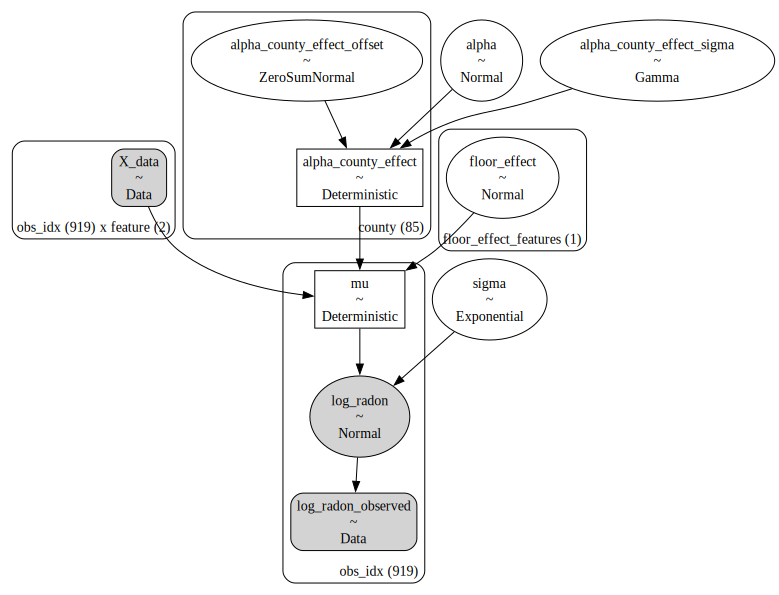

In [14]:
model_3.to_graphviz()

In [15]:
idata_3 = model_3.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, alpha_county_effect_sigma, alpha_county_effect_offset, floor_effect, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


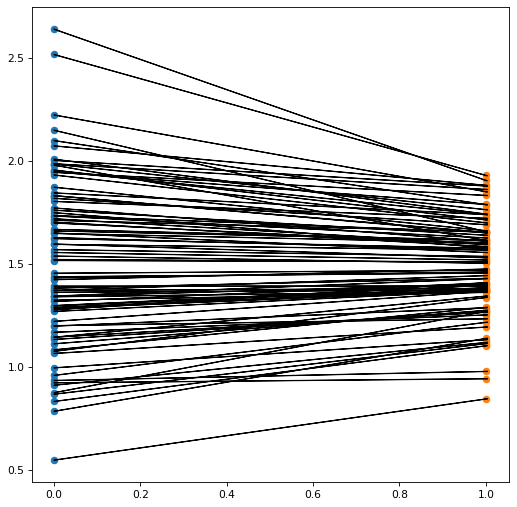

In [16]:
fig, ax = plt.subplots(figsize=(8, 8), dpi=77)
alpha_unpooled = idata_2.posterior.alpha_county_effect.mean(dim=["chain", "draw"]).values
alpha_pooled = idata_3.posterior.alpha_county_effect.mean(dim=["chain", "draw"]).values

ax.scatter(np.zeros_like(alpha_unpooled), alpha_unpooled)
ax.scatter(np.ones_like(alpha_pooled), alpha_pooled)

for y1, y2 in zip(alpha_unpooled, alpha_pooled):
    ax.arrow(0, y1, 1, y2 - y1)